In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sensorium.data import data
from sensorium.utils import utils, tensorboard

utils.set_random_seed(1234)

GRAY = cm.get_cmap("gray")
BACKGROUND_COLOR = "#ffffff"

In [2]:
dataset, metadata = data.load_mice_data(mice_dir="../data")

Loading: 100%|██████████| 7/7 [00:56<00:00,  8.10s/it]


In [3]:
for i in dataset.keys():
    print(
        f'Mouse {i+1}\t\tnum. neurons: {dataset[i]["response"].shape[1]}\t\tnum. trials: {dataset[i]["image"].shape[0]}'
    )

Mouse 1		num. neurons: 7776		num. trials: 6955
Mouse 2		num. neurons: 7538		num. trials: 6959
Mouse 3		num. neurons: 8372		num. trials: 5994
Mouse 4		num. neurons: 7344		num. trials: 5997
Mouse 5		num. neurons: 7334		num. trials: 5951
Mouse 6		num. neurons: 8107		num. trials: 5966
Mouse 7		num. neurons: 8098		num. trials: 5983


In [4]:
# normalize array to range [0, 1]
normalize = lambda a: (a - np.min(a)) / (np.max(a) - np.min(a))
# standardize array to 0 mean and unit variance
standardize = lambda a: (a - np.mean(a)) / np.std(a)

Plot mouse 3 responses

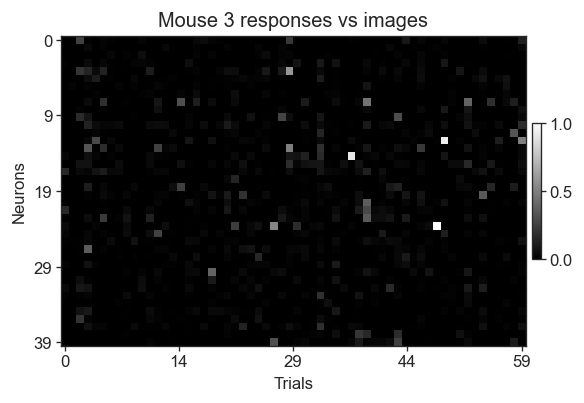

In [5]:
responses = normalize(dataset[2]["response"])

figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    gridspec_kw={"wspace": 0.05, "hspace": 0.01},
    figsize=(5, 5),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)


N_TRIALS, N_NEURONS = 60, 40
ax.imshow(responses[:N_TRIALS, :N_NEURONS].T, cmap=GRAY)

x_ticks = np.linspace(0, N_TRIALS - 1, 5)
tensorboard.set_xticks(
    axis=ax, ticks_loc=x_ticks, ticks=x_ticks.astype(int), label="Trials"
)
y_ticks = np.linspace(0, N_NEURONS - 1, 5)
tensorboard.set_yticks(
    axis=ax, ticks_loc=y_ticks, ticks=y_ticks.astype(int), label="Neurons"
)

# add colorbar
width, height = 0.015, ax.get_position().y1 * 0.3
cbar_ax = figure.add_axes(
    rect=[
        ax.get_position().x1 + 0.01,
        ((ax.get_position().y1 - ax.get_position().y0) / 2 + ax.get_position().y0)
        - (height / 2),
        width,
        height,
    ]
)
figure.colorbar(cm.ScalarMappable(cmap=GRAY), cax=cbar_ax, shrink=0.1)
tensorboard.set_yticks(
    axis=cbar_ax,
    ticks_loc=np.linspace(0, 1, 3),
    ticks=np.linspace(0, 1, 3),
    label="",
)
ax.set_title("Mouse 3 responses vs images")

tensorboard.save_figure(figure, filename='plots/mouse3_responses_v_images.png', dpi=240, close=False)

plt.show()
plt.close(figure)

Plot image - response pairs from Mouse 3

image dimension: (1, 144, 256)
number of neurons: 8372


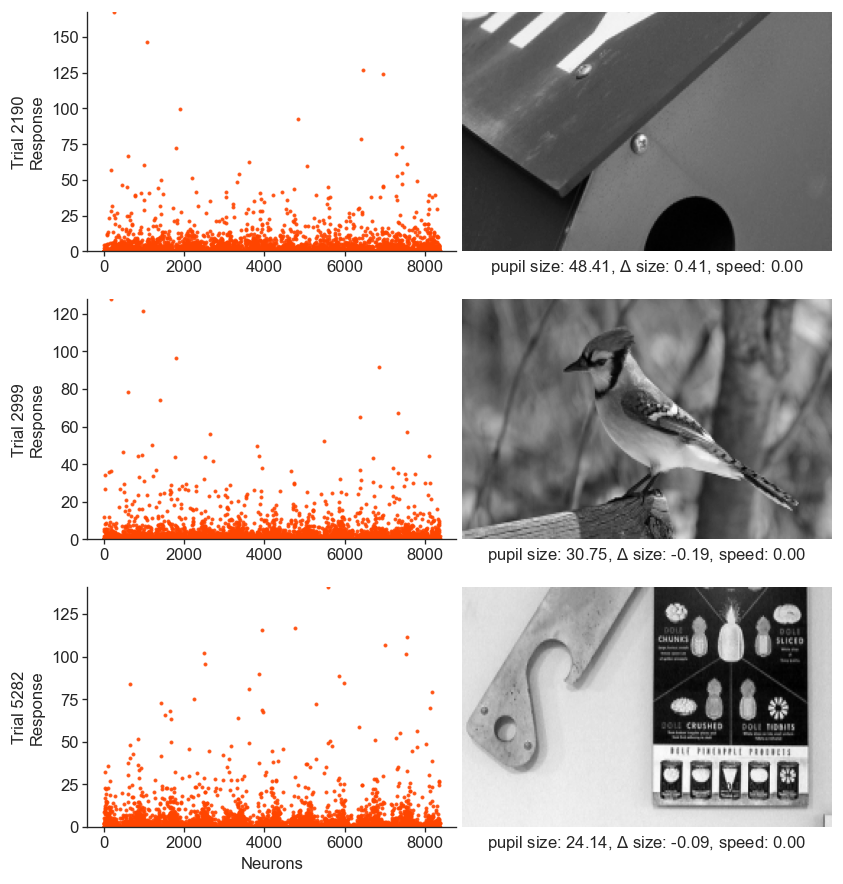

In [6]:
N_TRIALS = 3

images, responses, behaviors = (
    dataset[2]["image"],
    dataset[2]["response"],
    dataset[2]["behavior"],
)
print(
    f"image dimension: {images.shape[1:]}\n" f"number of neurons: {responses.shape[1]}"
)

figure, axes = plt.subplots(
    nrows=N_TRIALS,
    ncols=2,
    gridspec_kw={"wspace": 0.015, "hspace": 0.2},
    figsize=(8, 3 * N_TRIALS),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)

trials = np.random.choice(images.shape[0], size=N_TRIALS, replace=False)
x_axis = np.arange(responses.shape[1])

for i, trial in enumerate(trials):
    # plot response
    axes[i, 0].scatter(x=x_axis, y=responses[trial], s=2, alpha=0.8, color="orangered")
    axes[i, 0].set_facecolor(BACKGROUND_COLOR)
    axes[i, 0].set_ylabel(f"Trial {trial:03d}\nResponse")
    if i == N_TRIALS - 1:
        axes[i, 0].set_xlabel("Neurons")
    tensorboard.remove_top_right_spines(axis=axes[i, 0])
    axes[i, 0].set_ylim(np.min(responses[trial]), np.max(responses[trial]))
    # plot natural image
    axes[i, 1].imshow(normalize(images[trial][0]), cmap=GRAY, aspect="auto")
    axes[i, 1].set_xlabel(
        rf"pupil size: {behaviors[trial][0]:.02f}, $\Delta$ size: {behaviors[trial][1]:.02f}, speed: {behaviors[trial][2]:.02f}"
    )
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 1].tick_params(axis="both", which="both", pad=0, length=0)
    tensorboard.remove_spines(axis=axes[i, 1])

tensorboard.save_figure(figure, filename='plots/mouse3_responses_v_images_2.png', dpi=240, close=False)

plt.show()
plt.close(figure)

Plot Mouse 3 - 7 response distributions

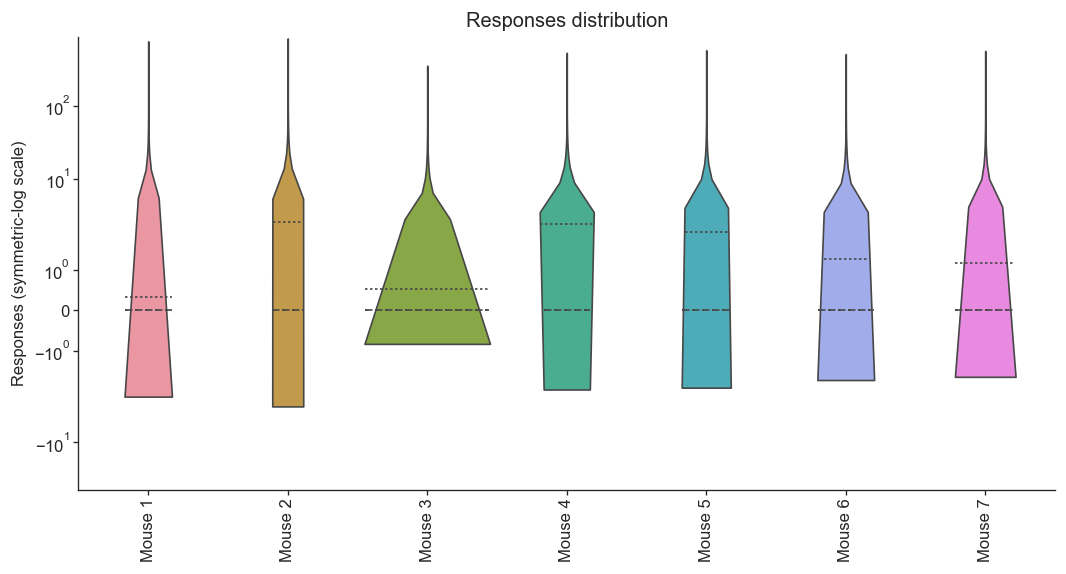

In [7]:
N_TRIALS = 100

figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
    figsize=(1.5 * len(dataset), 5),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)

responses = [dataset[i]["response"][:N_TRIALS].flatten() for i in dataset.keys()]
sns.violinplot(
    data=responses,
    scale="area",
    width=0.9,
    inner="quartile",
    linewidth=1,
    ax=ax,
)
ax.set_facecolor(BACKGROUND_COLOR)
ax.set_yscale("symlog")
ax.set_xticklabels(
    [f"Mouse {i+1}" for i in range(len(dataset))], va="top", ha="center", rotation=90
)
ax.set_xlim(left=-0.5, right=len(responses) - 0.5)

tensorboard.remove_top_right_spines(axis=ax)
ax.set_ylabel("Responses (symmetric-log scale)")
ax.set_title("Responses distribution")

tensorboard.save_figure(figure, filename='plots/response_distribution.png', dpi=240, close=False)

plt.show()
plt.close(figure)

Plot anatomical coordinates for mouse 2

coordinates min: [-809  -80  218]
coordinates max: [-194  536  263]


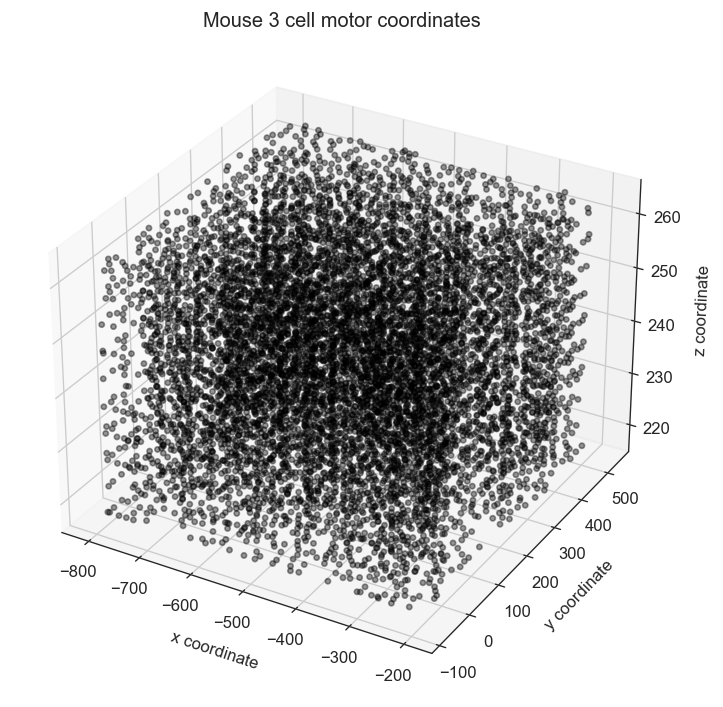

In [8]:
coordinates = metadata[2]["coordinates"]
print(
    f"coordinates min: {np.min(coordinates, axis=0)}\n"
    f"coordinates max: {np.max(coordinates, axis=0)}"
)

figure = plt.figure(figsize=(6, 6), dpi=120, facecolor=BACKGROUND_COLOR)
ax = figure.add_subplot(1, 1, 1, projection="3d", facecolor=BACKGROUND_COLOR)
ax.scatter3D(*coordinates.T, s=10, alpha=0.4, color="black")
ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")
ax.set_title("Mouse 3 cell motor coordinates")
figure.tight_layout()

tensorboard.save_figure(figure, filename='plots/mouse3_cell_coordinates.png', dpi=240, close=False)

plt.show()
plt.close(figure)